In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report
# Subir archivo CSV
from google.colab import files
uploaded = files.upload()
# Leer el archivo corregido
df = pd.read_csv('Anexo_ET_demo_round_traces_2022_corregido.csv', low_memory=False)
# Eliminar columna de índice innecesaria si existe
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])
# Vista previa del DataFrame
df.head()

Saving Anexo_ET_demo_round_traces_2022_corregido.csv to Anexo_ET_demo_round_traces_2022_corregido (4).csv


,600,de_inferno,Terrorist,1,4,1.1,False,True,False.1,False.2,...,0.1,0.2,0.3,0.4,750,4400,0.5,0.6,0.7,0.8
0,601,de_inferno,Terrorist,1,4,1,False,True,False,False,...,0,0,0,0,800,4400,0,0,0,0
1,602,de_inferno,Terrorist,1,4,1,False,True,False,False,...,0,0,0,0,1000,4400,0,0,0,0
2,603,de_inferno,Terrorist,1,4,1,False,True,False,False,...,0,0,0,0,850,4400,0,0,0,0
3,604,de_inferno,Terrorist,1,4,1,False,True,True,False,...,0,0,0,0,1000,4400,0,0,0,0
4,605,de_inferno,CounterTerrorist,2,4,1,True,False,True,False,...,0,0,0,0,850,3750,0,0,0,0


**1.- limpieza de datos**

In [41]:
# Nombres correctos de las columnas
column_names = [
    'PlayerId', 'Map', 'Team', 'InternalTeamId', 'MatchId', 'RoundId', 'RoundWinner',
    'MatchWinner', 'Survived', 'AbnormalMatch', 'TimeAlive', 'TravelledDistance',
    'RLethalGrenadesThrown', 'RNonLethalGrenadesThrown', 'PrimaryAssaultRifle',
    'PrimarySniperRifle', 'PrimaryHeavy', 'PrimarySMG', 'PrimaryPistol', 'FirstKillTime',
    'RoundKills', 'RoundAssists', 'RoundHeadshots', 'RoundFlankKills',
    'RoundStartingEquipmentValue', 'TeamStartingEquipmentValue', 'MatchKills',
    'MatchFlankKills', 'MatchAssists', 'MatchHeadshots'
]

# Leer archivo CSV sin encabezado y asignar nombres correctos
df = pd.read_csv('Anexo_ET_demo_round_traces_2022_corregido.csv', header=None, names=column_names)

# Ver resumen del dataset
original_shape = df.shape
print("Dimensiones originales:", original_shape)
print("\nValores nulos por columna:\n", df.isnull().sum())

# Columnas a convertir
cols_to_numeric = [
    'TimeAlive', 'TravelledDistance', 'RoundAssists', 'RoundHeadshots',
    'RoundStartingEquipmentValue', 'RoundKills', 'MatchKills', 'TeamStartingEquipmentValue'
]

# Convertir columnas a numéricas
for col in cols_to_numeric:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    else:
        print(f"Warning: Column '{col}' not found in DataFrame.")

# Eliminar filas con nulos en variables clave
df = df.dropna(subset=['MatchKills', 'TeamStartingEquipmentValue'])

# Convertir 'Survived' a booleano si existe
if 'Survived' in df.columns:
    df['Survived'] = df['Survived'].astype(bool)

# Verificación final
print("\nDimensiones después de limpieza:", df.shape)
print(f"Filas eliminadas: {original_shape[0] - df.shape[0]}")

# Resumen estadístico
cols_to_describe = [col for col in cols_to_numeric if col in df.columns]
print("\nResumen estadístico:")
print(df[cols_to_describe].describe())


<ipython-input-41-d651fc2ac279>:13: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Anexo_ET_demo_round_traces_2022_corregido.csv', header=None, names=column_names)


Dimensiones originales: (79157, 30)

Valores nulos por columna:
 PlayerId                       0
Map                            0
Team                           2
InternalTeamId                 0
MatchId                        0
RoundId                        0
RoundWinner                    0
MatchWinner                    1
Survived                       0
AbnormalMatch                  0
TimeAlive                      0
TravelledDistance              0
RLethalGrenadesThrown          0
RNonLethalGrenadesThrown       0
PrimaryAssaultRifle            0
PrimarySniperRifle             0
PrimaryHeavy                   0
PrimarySMG                     0
PrimaryPistol                  0
FirstKillTime                  0
RoundKills                     0
RoundAssists                   0
RoundHeadshots                 0
RoundFlankKills                0
RoundStartingEquipmentValue    0
TeamStartingEquipmentValue     0
MatchKills                     0
MatchFlankKills                0
MatchAssist

**grafico limpieza de datos**

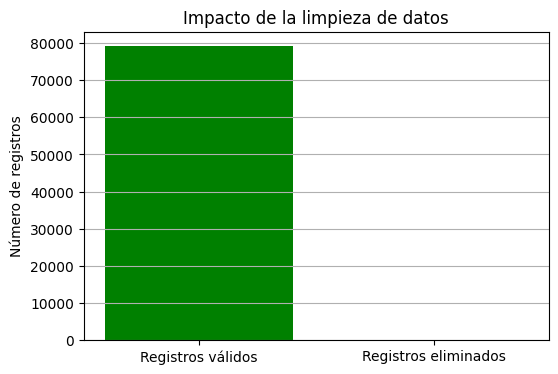

In [42]:
# Visualizar impacto de la limpieza de datos
registros_validos = df.shape[0]
registros_eliminados = original_shape[0] - registros_validos

etiquetas = ['Registros válidos', 'Registros eliminados']
valores = [registros_validos, registros_eliminados]

plt.figure(figsize=(6,4))
plt.bar(etiquetas, valores, color=['green', 'red'])
plt.title("Impacto de la limpieza de datos")
plt.ylabel("Número de registros")
plt.grid(axis='y')
plt.show()


**2.-Regresión lineal simple**

MSE: 37.5177
Coeficiente (pendiente): 0.0001
Intercepto: 6.3668


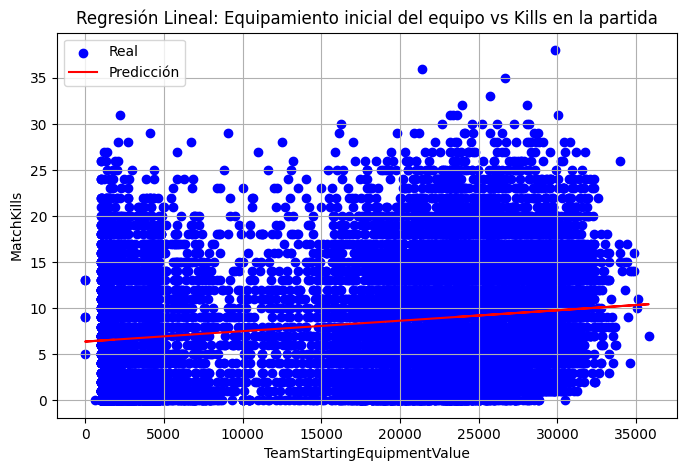

In [43]:
# Asegurar que los datos sean numéricos
df['MatchKills'] = pd.to_numeric(df['MatchKills'], errors='coerce')
df['TeamStartingEquipmentValue'] = pd.to_numeric(df['TeamStartingEquipmentValue'], errors='coerce')

# Eliminar registros con valores nulos
df = df.dropna(subset=['MatchKills', 'TeamStartingEquipmentValue'])

# Definir variable independiente (X) y dependiente (y)
X = df[['TeamStartingEquipmentValue']]
y = df['MatchKills']
# Asegurar que los datos sean numéricos
df['MatchKills'] = pd.to_numeric(df['MatchKills'], errors='coerce')
df['TeamStartingEquipmentValue'] = pd.to_numeric(df['TeamStartingEquipmentValue'], errors='coerce')

# Eliminar registros con valores nulos
df = df.dropna(subset=['MatchKills', 'TeamStartingEquipmentValue'])

# Definir variable independiente (X) y dependiente (y)
X = df[['TeamStartingEquipmentValue']]
y = df['MatchKills']

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Crear y entrenar modelo
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predicciones
y_pred = lr.predict(X_test)

# Evaluación
print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"Coeficiente (pendiente): {lr.coef_[0]:.4f}")
print(f"Intercepto: {lr.intercept_:.4f}")

# Visualización
plt.figure(figsize=(8, 5))
plt.scatter(X_test, y_test, color='blue', label='Real')
plt.plot(X_test, y_pred, color='red', label='Predicción')
plt.xlabel('TeamStartingEquipmentValue')
plt.ylabel('MatchKills')
plt.title('Regresión Lineal: Equipamiento inicial del equipo vs Kills en la partida')
plt.legend()
plt.grid(True)
plt.show()


**3.- regrecion lineal multiple**

📊 MSE (Regresión múltiple): 57.9617

🔍 Coeficientes de cada variable:
TeamStartingEquipmentValue: -0.0005
RoundStartingEquipmentValue: 0.0015
TimeAlive: -0.2709
TravelledDistance: 0.0000

Intercepto: 5.2807


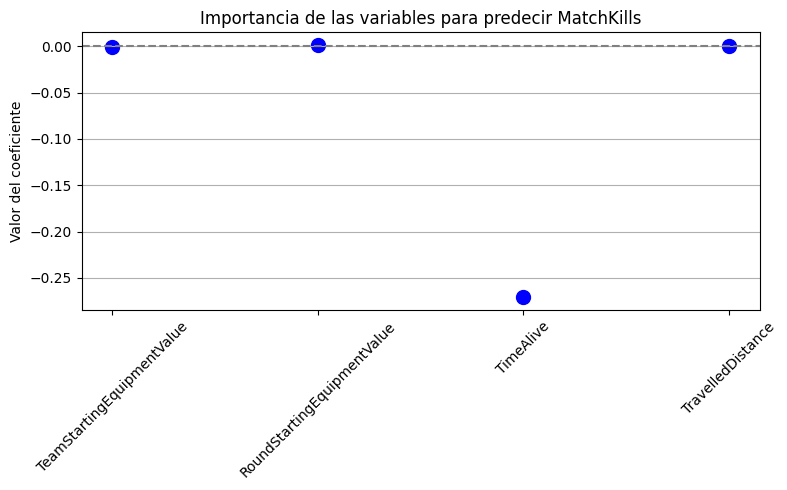

In [44]:
# Variables predictoras (TeamStartingEquipmentValue incluida como principal)
features = [
    'TeamStartingEquipmentValue',
    'RoundStartingEquipmentValue',
    'TimeAlive',
    'TravelledDistance'
]

# Asegurarse de que las columnas sean numéricas
df[features + ['MatchKills']] = df[features + ['MatchKills']].apply(pd.to_numeric, errors='coerce')

# Eliminar filas con valores faltantes
df = df.dropna(subset=features + ['MatchKills'])

# Separar X e y
X = df[features]
y = df['MatchKills']

# Separar entrenamiento/prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar modelo
lr_multi = LinearRegression()
lr_multi.fit(X_train, y_train)

# Predecir
y_pred = lr_multi.predict(X_test)

# Mostrar evaluación
print("📊 MSE (Regresión múltiple):", round(mean_squared_error(y_test, y_pred), 4))
print("\n🔍 Coeficientes de cada variable:")
for feature, coef in zip(features, lr_multi.coef_):
    print(f"{feature}: {coef:.4f}")
print(f"\nIntercepto: {lr_multi.intercept_:.4f}")


# Visualización de coeficientes con puntos
plt.figure(figsize=(8, 5))
plt.scatter(features, lr_multi.coef_, color='blue', s=100)
plt.axhline(0, color='gray', linestyle='--')
plt.title('Importancia de las variables para predecir MatchKills')
plt.ylabel('Valor del coeficiente')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**4.- Árbol de decisión (clasificación)**

In [45]:


# Variables predictoras (añadimos contexto)
features = [
    'TeamStartingEquipmentValue',
    'RoundStartingEquipmentValue',
    'TimeAlive',
    'TravelledDistance',
    'RoundAssists',
    'RoundHeadshots'
]

# Asegurar que sean numéricas
df[features + ['MatchKills']] = df[features + ['MatchKills']].apply(pd.to_numeric, errors='coerce')
df = df.dropna(subset=features + ['MatchKills'])

# Variable objetivo: 1 si MatchKills >= 5, 0 si no
df['HighKills'] = (df['MatchKills'] >= 5).astype(int)

# ---------- Balanceo del dataset ----------
df_majority = df[df['HighKills'] == 0]
df_minority = df[df['HighKills'] == 1]

# Sobremuestreo de la clase minoritaria
df_minority_upsampled = resample(df_minority,
                                 replace=True,
                                 n_samples=len(df_majority),
                                 random_state=42)

# Dataset balanceado
df_balanced = pd.concat([df_majority, df_minority_upsampled])

# Separar X e y
X = df_balanced[features]
y = df_balanced['HighKills']

# División entrenamiento / prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---------- Entrenamiento del modelo ----------
tree = DecisionTreeClassifier(max_depth=None, min_samples_split=2, random_state=42)
tree.fit(X_train, y_train)

# ---------- Evaluación ----------
y_pred = tree.predict(X_test)

print("📊 Accuracy Árbol de Decisión:", round(accuracy_score(y_test, y_pred), 4))
print("\n📌 Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))
print("\n📄 Reporte de Clasificación:")
print(classification_report(y_test, y_pred))


📊 Accuracy Árbol de Decisión: 0.8824

📌 Matriz de Confusión:
[[7 2]
 [0 8]]

📄 Reporte de Clasificación:
              precision    recall  f1-score   support

           0       1.00      0.78      0.88         9
           1       0.80      1.00      0.89         8

    accuracy                           0.88        17
   macro avg       0.90      0.89      0.88        17
weighted avg       0.91      0.88      0.88        17



**5.- Random Forest**

In [47]:

# Variables predictoras
features = [
    'TeamStartingEquipmentValue',
    'RoundStartingEquipmentValue',
    'TimeAlive',
    'TravelledDistance',
    'RoundAssists',
    'RoundHeadshots'
]

# Asegurar que sean numéricas
df[features + ['MatchKills']] = df[features + ['MatchKills']].apply(pd.to_numeric, errors='coerce')
df = df.dropna(subset=features + ['MatchKills'])

# Crear variable objetivo binaria: alto desempeño
df['HighKills'] = (df['MatchKills'] >= 5).astype(int)

# Balancear clases con sobremuestreo
df_majority = df[df['HighKills'] == 0]
df_minority = df[df['HighKills'] == 1]

df_minority_upsampled = resample(df_minority,
                                 replace=True,
                                 n_samples=len(df_majority),
                                 random_state=42)

df_balanced = pd.concat([df_majority, df_minority_upsampled])

# Preparar datos
X = df_balanced[features]
y = df_balanced['HighKills']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --------- Entrenamiento Random Forest ---------
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# --------- Evaluación ---------
y_pred = rf.predict(X_test)

print("🌲 Accuracy Random Forest:", round(accuracy_score(y_test, y_pred), 4))
print("\n📌 Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))
print("\n📄 Reporte de Clasificación:")
print(classification_report(y_test, y_pred))


🌲 Accuracy Random Forest: 0.8824

📌 Matriz de Confusión:
[[7 2]
 [0 8]]

📄 Reporte de Clasificación:
              precision    recall  f1-score   support

           0       1.00      0.78      0.88         9
           1       0.80      1.00      0.89         8

    accuracy                           0.88        17
   macro avg       0.90      0.89      0.88        17
weighted avg       0.91      0.88      0.88        17



In [48]:


# Variables predictoras
features = [
    'TeamStartingEquipmentValue',
    'RoundStartingEquipmentValue',
    'TimeAlive',
    'TravelledDistance',
    'RoundAssists',
    'RoundHeadshots'
]

# Asegurar que sean numéricas
df[features + ['MatchKills']] = df[features + ['MatchKills']].apply(pd.to_numeric, errors='coerce')
df = df.dropna(subset=features + ['MatchKills'])

# Crear variable binaria: alto rendimiento
df['HighKills'] = (df['MatchKills'] >= 5).astype(int)

# Balanceo de clases
df_majority = df[df['HighKills'] == 0]
df_minority = df[df['HighKills'] == 1]

df_minority_upsampled = resample(df_minority,
                                 replace=True,
                                 n_samples=len(df_majority),
                                 random_state=42)

df_balanced = pd.concat([df_majority, df_minority_upsampled])

# Preparar datos para el modelo
X = df_balanced[features]
y = df_balanced['HighKills']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --------- Entrenamiento del modelo SVM ---------
svm = SVC(kernel='linear', C=1.0, random_state=42)
svm.fit(X_train, y_train)

# --------- Evaluación ---------
y_pred = svm.predict(X_test)

print("🔍 Accuracy SVM:", round(accuracy_score(y_test, y_pred), 4))
print("\n📌 Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))
print("\n📄 Reporte de Clasificación:")
print(classification_report(y_test, y_pred))


🔍 Accuracy SVM: 0.8235

📌 Matriz de Confusión:
[[6 3]
 [0 8]]

📄 Reporte de Clasificación:
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         9
           1       0.73      1.00      0.84         8

    accuracy                           0.82        17
   macro avg       0.86      0.83      0.82        17
weighted avg       0.87      0.82      0.82        17



**comparativa final**

In [52]:
modelos = {
    'Arbol': DecisionTreeClassifier(max_depth=4, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='linear', random_state=42)
}

resultados = {}

for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    resultados[nombre] = acc
